In [34]:
import os
import pickle
import matplotlib.pyplot as plt
import statsmodels.api as sm
from Library.preprocess import *
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from matplotlib import font_manager, rc


plt.rcParams['axes.unicode_minus'] = False
rc('font', family='AppleGothic')
pd.set_option('display.max_columns', None)
print(f"CPU count : {os.cpu_count()}")

CPU count : 8


### 미드필더 데이터셋 로드

In [2]:
with open('datas/midfield.pkl', 'rb') as f:
    midfield_df = pickle.load(f)

In [4]:
midfield_df = preprocess_df(midfield_df)
midfield_df.tail()

,market_value,app,conceded_goals,clean_sheets,yellow_card,second_yell,red_card,age,height,position,foot,club,outfitter,cup,Tackles,Inter,Fouls,Offsides,Clear,Drbed,Blocks,OwnG,Rating,Goals,Assists,SpG,Fouled,Off,Disp,UnsTch,Drb,KeyP,AvgP,PS,Crosses,LongB,ThrB,AerialsWon,MotM,period,total_out
638,3600000,38,0.289474,0.0,0.078947,0.0,0.0,28,181,RightMidfield,right,0,Nike,0,1.4,0.9,0.8,0.0,1.2,1.5,0.3,0.0,6.74,0.289474,0.026316,1.8,1.7,0.1,1.3,1.9,0.7,0.5,27.7,69.5,0.2,1.1,0.1,1.9,0.0,4.0,0.0
639,270000,2,0.000000,0.0,0.000000,0.0,0.0,23,181,RightMidfield,right,0,Nike,0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.03,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,50.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
640,2700000,30,0.133333,0.1,0.033333,0.0,0.0,25,178,LeftMidfield,left,0,Nike,0,0.9,0.8,0.8,0.0,0.4,0.4,0.0,0.0,6.60,0.133333,0.100000,0.8,1.4,0.1,0.4,1.5,0.3,1.2,12.4,69.0,1.3,0.4,0.0,0.6,1.0,3.0,0.0
641,720000,20,0.000000,0.1,0.050000,0.0,0.0,27,185,LeftMidfield,right,0,Nike,1,0.8,0.4,0.5,0.1,0.1,0.8,0.0,0.0,6.45,0.000000,0.100000,0.8,0.6,0.1,0.9,1.2,1.6,0.7,13.9,78.7,0.2,0.6,0.1,0.6,0.0,2.0,0.0
642,2700000,23,0.000000,0.0,0.086957,0.0,0.0,22,170,AttackingMidfield,right,0,Nike,0,0.7,0.2,0.3,0.0,0.2,0.8,0.0,0.0,6.34,0.000000,0.000000,0.8,1.1,0.0,1.3,2.0,0.7,1.1,22.0,82.6,0.9,1.4,0.1,0.3,0.0,3.0,0.0


#### categorical variances 더미변수화

In [5]:
model_df = pd.get_dummies(midfield_df, columns=['position', 'foot', 'outfitter'])

### 초기 모델
- 범주형 : 더미변수화
- 수치형 : 전처리만 진행
- 종속변수 : original

In [6]:
dfX0 = model_df.loc[:, 'app':]
dfy = model_df['market_value']

train_X, test_X, train_y, test_y = train_test_split(dfX0, dfy, test_size=0.3, random_state=3)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(450, 49) (450,) (193, 49) (193,)


MSE :  84347565902231.3
RMSE :  9184093.090895329
r2-score :  0.5205764132998216


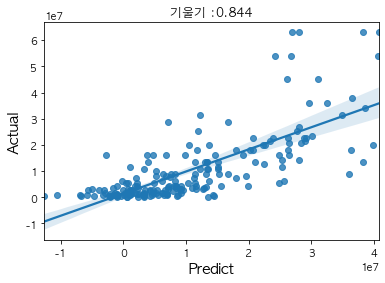

In [7]:
model_lm = LinearRegression(fit_intercept=True).fit(train_X, train_y)
pred_lm = model_lm.predict(test_X)

print("MSE : ", mean_squared_error(test_y, pred_lm))
print("RMSE : ", np.sqrt(mean_squared_error(test_y, pred_lm)))
print("r2-score : ",r2_score(test_y, pred_lm))
f = np.polyfit(pred_lm, test_y, deg=1)

sns.regplot(x=pred_lm, y=test_y)
plt.title(f"기울기 :{f[0].round(3)}")
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.show()

### Standard, MinMax, Robust 모델 비교
- 범주형 : 더미변수화
- 수치형 : 각 스케일러 적용
- 종속변수 : original

In [9]:
ss = StandardScaler().fit(dfX0.loc[:, "app":].values)
mm = MinMaxScaler().fit(dfX0.loc[:, "app":].values)
rb = RobustScaler().fit(dfX0.loc[:, "app":].values)

ss_values = ss.transform(dfX0.loc[:, "app":].values)
mm_values = mm.transform(dfX0.loc[:, "app":].values)
rb_values = rb.transform(dfX0.loc[:, "app":].values)

ss_dfX0 = ss_values
mm_dfX0 = mm_values
rb_dfX0 = rb_values

In [12]:
train_X, test_X, train_y, test_y = train_test_split(ss_dfX0, dfy, test_size=0.3, random_state=3)

ss_model = LinearRegression(fit_intercept=True).fit(train_X, train_y)
pred_ss = ss_model.predict(test_X)

print("S-scaled MSE : ", mean_squared_error(test_y, pred_ss))
print("S-scaled RMSE : ",np.sqrt(mean_squared_error(test_y, pred_ss)))
print("S-scaled r2-score : ",r2_score(test_y, pred_ss))

S-scaled MSE :  84206000415817.12
S-scaled RMSE :  9176382.752251407
S-scaled r2-score :  0.5213810581348406


In [13]:
train_X, test_X, train_y, test_y = train_test_split(mm_dfX0, dfy, test_size=0.3, random_state=3)

mm_model = LinearRegression(fit_intercept=True).fit(train_X, train_y)
pred_mm = mm_model.predict(test_X)

print("M-scaled MSE : ",mean_squared_error(test_y, pred_mm))
print("M-scaled RMSE : ",np.sqrt(mean_squared_error(test_y, pred_mm)))
print("M-scaled r2-score : ",r2_score(test_y, pred_mm))

M-scaled MSE :  106629456844749.92
M-scaled RMSE :  10326154.019999407
M-scaled r2-score :  0.3939282526818054


In [14]:
train_X, test_X, train_y, test_y = train_test_split(rb_dfX0, dfy, test_size=0.3, random_state=3)

rb_model = LinearRegression(fit_intercept=True).fit(train_X, train_y)
pred_rb = rb_model.predict(test_X)

print("R-scaled MSE : ",mean_squared_error(test_y, pred_rb))
print("R-scaled RMSE : ",np.sqrt(mean_squared_error(test_y, pred_rb)))
print("R-scaled r2-score : ",r2_score(test_y, pred_rb))

R-scaled MSE :  84347565902231.12
R-scaled RMSE :  9184093.09089532
R-scaled r2-score :  0.5205764132998226


In [15]:
f1 = np.polyfit(pred_ss, test_y, deg=1)
f2 = np.polyfit(pred_mm, test_y, deg=1)
f3 = np.polyfit(pred_rb, test_y, deg=1)

S-scaled r2-score :  0.5213810581348406
M-scaled r2-score :  0.3939282526818054
R-scaled r2-score :  0.5205764132998226


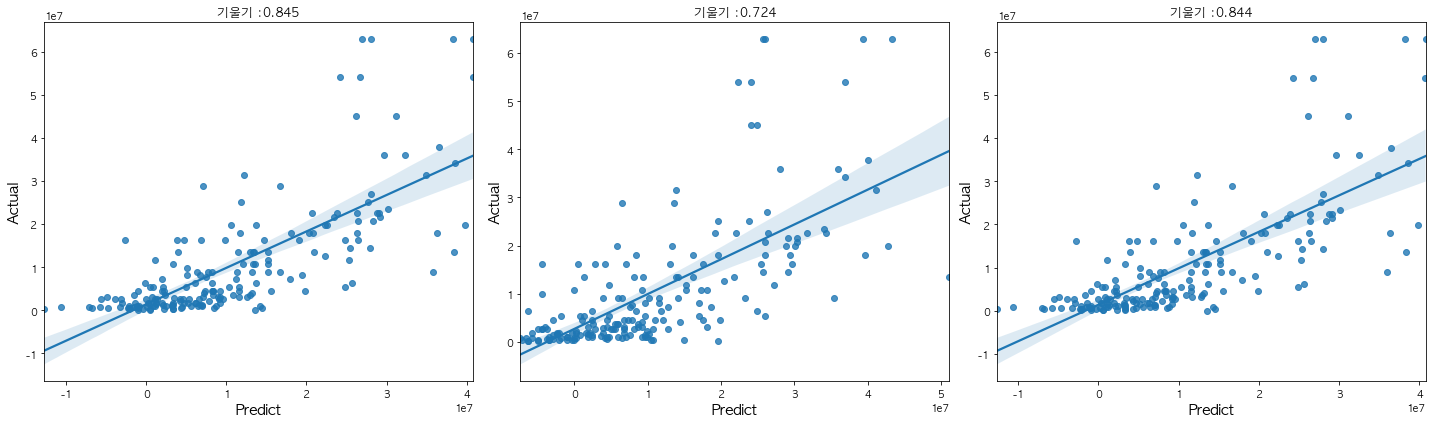

In [16]:
print("S-scaled r2-score : ",r2_score(test_y, pred_ss))
print("M-scaled r2-score : ",r2_score(test_y, pred_mm))
print("R-scaled r2-score : ",r2_score(test_y, pred_rb))

plt.figure(figsize=(20, 6))

plt.subplot(131)
sns.regplot(x=pred_ss, y=test_y)
plt.title(f"기울기 :{f1[0].round(3)}")
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.subplot(132)
sns.regplot(x=pred_mm, y=test_y)
plt.title(f"기울기 :{f2[0].round(3)}")
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.subplot(133)
sns.regplot(x=pred_rb, y=test_y)
plt.title(f"기울기 :{f3[0].round(3)}")
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.tight_layout()
plt.show()

### 종속변수에 log scaling을 진행한 모델
- 범주형 : 더미변수화
- 수치형 : Standard Scaler
- 종속변수 : log1p Scaler

In [17]:
log_dfy = np.log1p(model_df['market_value'])

train_X, test_X, train_y, test_y = train_test_split(ss_dfX0, log_dfy, test_size=0.3, random_state=3)

log_scaled MSE :  0.8258623798885549
log_scaled RMSE :  0.9087697067401371
Inverse log한 RMSE :  9973871.849136319
log_scaled r2-score :  0.6041342027075107


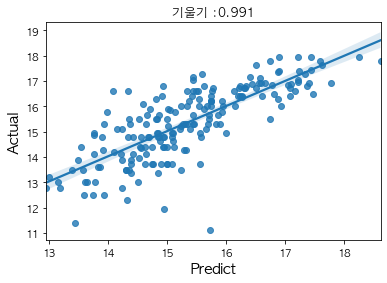

In [18]:
model_log = LinearRegression(fit_intercept=True).fit(train_X, train_y)
pred_log = model_log.predict(test_X)
f = np.polyfit(pred_log, test_y, deg=1)

print("log_scaled MSE : ", mean_squared_error(test_y, pred_log))
print("log_scaled RMSE : ",np.sqrt(mean_squared_error(test_y, pred_log)))
print("Inverse log한 RMSE : ", np.sqrt(np.sum((((np.exp(test_y) -1) - (np.exp(pred_log) -1))**2)) / len(test_y)))
print("log_scaled r2-score : ",r2_score(test_y, pred_log))

sns.regplot(x=pred_log, y=test_y)
plt.title(f"기울기 :{f[0].round(3)}")
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.show()

### RandomForest Regessor Model 적용
- 범주형 : 더미변수화
- 수치형 : Standard Scaler
- 종속변수 : original and log1p Scaler

In [19]:
train_X, test_X, train_y, test_y = train_test_split(ss_dfX0, dfy, test_size=0.3, random_state=3)

rf_model = RandomForestRegressor().fit(train_X, train_y)
pred_rf = rf_model.predict(test_X)

print("RF MSE : ", mean_squared_error(test_y, pred_rf))
print("RF RMSE : ",np.sqrt(mean_squared_error(test_y, pred_rf)))
print("RF r2-score : ",r2_score(test_y, pred_rf))

RF MSE :  83914839577863.22
RF RMSE :  9160504.329886166
RF r2-score :  0.523035988798759


In [20]:
train_X, test_X, train_y, test_y = train_test_split(ss_dfX0, log_dfy, test_size=0.3, random_state=3)

rf_log_model = RandomForestRegressor().fit(train_X, train_y)
pred_rf_log = rf_log_model.predict(test_X)

print("log_RF MSE : ", mean_squared_error(test_y, pred_rf_log))
print("log_RF RMSE : ",np.sqrt(mean_squared_error(test_y, pred_rf_log)))
print("log_RF r2-score : ",r2_score(test_y, pred_rf_log))

log_RF MSE :  0.7984356718153595
log_RF RMSE :  0.8935522770467095
log_RF r2-score :  0.6172808188059085


### GridSearchCV를 통한 best hyper parameter 추출
- model : RandomForest Regessor
- 범주형 : 더미변수화
- 수치형 : Standard Scaler
- 종속변수 : log1p Scaler

In [22]:
random_params = {
 'max_depth': [3,5,9],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5],
 'n_estimators': [200, 800]
}

result = GridSearchCV(
    RandomForestRegressor(),
    param_grid=random_params,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1)

result.fit(train_X, train_y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 5, 9], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [200, 800]},
             scoring='neg_mean_squared_error', verbose=1)

In [24]:
params = result.best_params_
params

{'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}

In [25]:
grid_model = RandomForestRegressor(**params).fit(train_X, train_y)
pred_grid = grid_model.predict(test_X)

print(mean_squared_error(test_y, pred_grid))
print(np.sqrt(mean_squared_error(test_y, pred_grid)))
print(r2_score(test_y, pred_grid))

0.80805598213236
0.8989193412828317
0.6126694550889239


### Pipeline을 이용한 Model 생성
- ploynomialFeatures을 이용한 다향회귀 진행 : 삼차항
- pipeline : `PolynomialFeatures > StandardScaler > RandomForestRegressor`
- 범주형 : 더미변수화
- 수치형 : Standard Scaler
- 종속변수 : log1p Scaler

In [26]:
pipe = Pipeline([
    ('ploy', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor())
])

pipe_params = {
    'rf__min_samples_leaf': [2, 4, 8],
    'rf__min_samples_split': [2, 4, 8],
    'rf__n_estimators': [200, 1000]
}

pipe_grid = HalvingGridSearchCV(pipe, param_grid=pipe_params, verbose=2, n_jobs=os.cpu_count()-2,
                                scoring="roc_auc", min_resources="exhaust", cv=3)
pipe_grid.fit(train_X, train_y)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 50
max_resources_: 450
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 50
Fitting 3 folds for each of 18 candidates, totalling 54 fits
----------
iter: 1
n_candidates: 6
n_resources: 150
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 2
n_resources: 450
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('ploy',
                                               PolynomialFeatures(degree=3)),
                                              ('scaler', StandardScaler()),
                                              ('rf', RandomForestRegressor())]),
                    n_jobs=6,
                    param_grid={'rf__min_samples_leaf': [2, 4, 8],
                                'rf__min_samples_split': [2, 4, 8],
                                'rf__n_estimators': [200, 1000]},
                    refit=<function _refit_callable at 0x14cbff160>,
                    scoring='roc_auc', verbose=2)

In [27]:
pipe_grid.best_params_

{'rf__min_samples_leaf': 8,
 'rf__min_samples_split': 8,
 'rf__n_estimators': 200}

In [28]:
pipe_2 = Pipeline([
    ('ploy', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(min_samples_leaf=8,
                                min_impurity_split=8,
                                n_estimators=200))
])

pipe_2_grid = pipe_2.fit(train_X, train_y)
pred_pipe_2 = pipe_2_grid.predict(test_X)

print(mean_squared_error(test_y, pred_pipe_2))
print(np.sqrt(mean_squared_error(test_y, pred_pipe_2)))
print(r2_score(test_y, pred_pipe_2))

2.088258781749133
1.44508089107466
-0.000978186827830907


### 최종 모델 선정 및 OLS객체를 통한 통계분석
- model : 일차항 gridSearchCV의 best-parameters Model
- 범주형 : 더미변수화
- 수치형 : Standard Scaler
- 종속변수 : log1p Scaler

In [29]:
train_X, test_X, train_y, test_y1 = train_test_split(dfX0, dfy, test_size=0.3, random_state=3)
train_X, test_X, train_y, test_y2 = train_test_split(ss_dfX0, log_dfy, test_size=0.3, random_state=3)

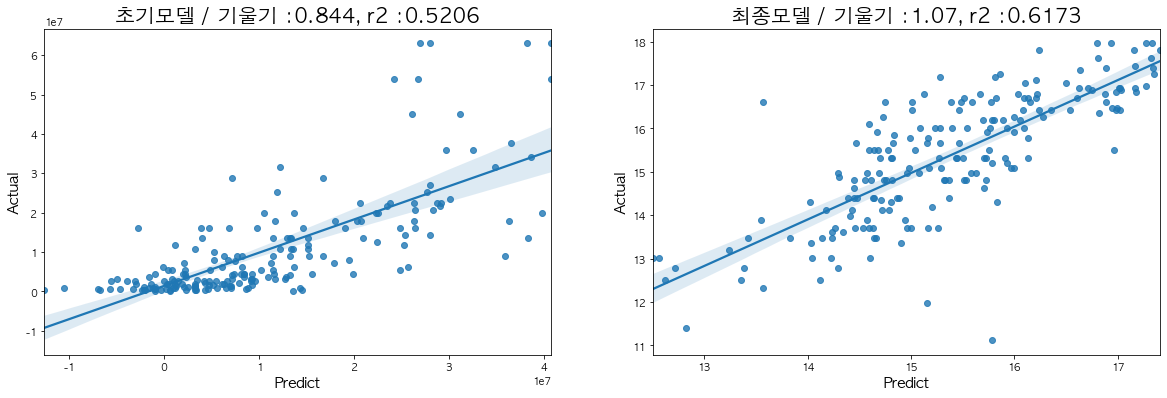

In [33]:
f1 = np.polyfit(pred_lm, test_y1, deg=1)
f2 = np.polyfit(pred_rf_log, test_y2, deg=1)

plt.figure(figsize=(20, 6))

plt.subplot(121)
sns.regplot(x=pred_lm, y=test_y1)
plt.title(f"초기모델 / 기울기 :{f1[0].round(3)}, r2 :{np.round(r2_score(test_y1, pred_lm), 4)}", fontsize=20)
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.subplot(122)
sns.regplot(x=pred_rf_log, y=test_y2)
plt.title(f"최종모델 / 기울기 :{f2[0].round(3)}, r2 :{np.round(r2_score(test_y2, pred_rf_log), 4)}", fontsize=20)
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.show()

In [41]:
final_model = RandomForestRegressor().fit(ss_dfX0, log_dfy)

In [69]:
result_df = pd.DataFrame(final_model.feature_importances_)
result_df.sort_values(0, ascending=False , inplace=True)
result_df['var'] = dfX0.columns

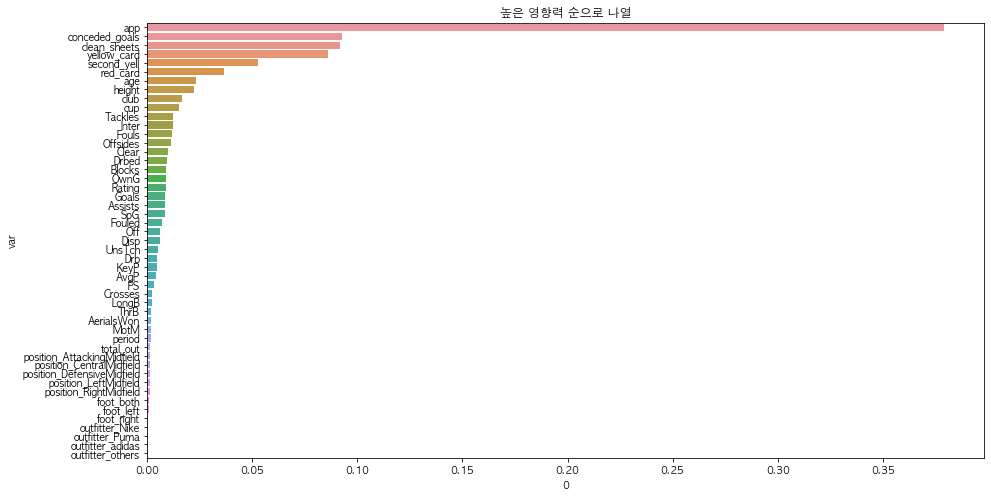

In [73]:
plt.figure(figsize=(15, 8))

sns.barplot(data=result_df, x=0, y='var', orient="h")
plt.title("높은 영향력 순으로 나열")

plt.show()

In [75]:
X0 = pd.DataFrame(ss_dfX0, columns=dfX0.columns)
X1 = sm.add_constant(X0)
y = log_dfy

final_ols_model = sm.OLS(y, X1).fit()
print(final_ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:           market_value   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     30.71
Date:                Fri, 11 Jun 2021   Prob (F-statistic):          3.07e-126
Time:                        19:49:16   Log-Likelihood:                -745.23
No. Observations:                 643   AIC:                             1582.
Df Residuals:                     597   BIC:                             1788.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [76]:
# p-value <= 0.1인 index 추출
idx = final_ols_model.pvalues[1:] <= 0.1

final_ols_model.params[1:][idx]

app                       0.288085
conceded_goals           -0.228275
age                      -0.327569
height                    0.067938
club                      0.315855
cup                       0.143541
Inter                    -0.119991
Goals                     0.280756
SpG                       0.110691
Off                       0.096886
Disp                      0.137785
AvgP                      0.490224
PS                        0.076232
LongB                    -0.126087
period                    0.213480
position_RightMidfield   -0.062428
foot_both                -0.068316
dtype: float64

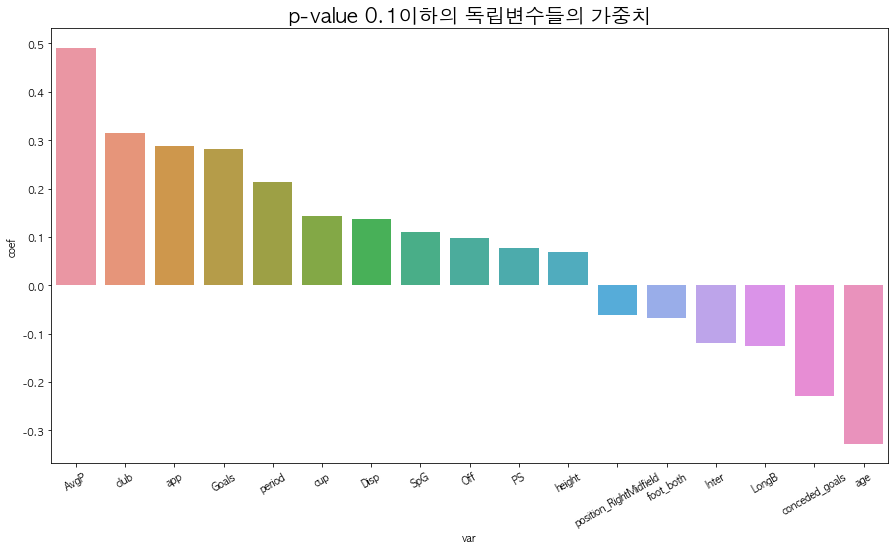

In [78]:
result_df = final_ols_model.params[1:][idx].reset_index().rename(columns={"index": "var", 0: "coef"})
result_df.sort_values('coef', ascending=False, inplace=True)

plt.figure(figsize=(15, 8))

sns.barplot(data=result_df, x='var', y='coef')
plt.title("p-value 0.1이하의 독립변수들의 가중치", fontsize=20)
plt.xticks(rotation=30)

plt.show()